### Importing needed libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
import requests

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from tqdm.notebook import tqdm


import spacy
nlp = spacy.load('en_core_web_lg')

from wordcloud import WordCloud

%matplotlib inline

### Customer importing the link

In [2]:
choice = input('If you want to run existing Amazon page press 1, if you want to add a new Amazon product press 2:\n').strip()

status = True

while status:
    if not choice  in ['1', '2']:
        print('Please enter either 1 or 2')
        choice = input('If you want to run existing Amazon page press 1, if you want to add a new Amazon product press 2:\n').strip()
    
    elif choice == '1':
        url = 'https://www.amazon.com/Apple-MU8F2AM-A-Pencil-Generation/product-reviews/B07K1WWBJK/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=2'
        status = False
    
    else:
        add_url = input('To choose another product, please follow these steps:\n1-Go to product page.\n2-Click on \'See all reviews\' in the product page.\n3-Press \'Next Page\'.\n4-Copy the link of this second page and paste it below.\n\n').strip()
        start = 'https://www.amazon.com'
        end = '2'
        
        start_url = add_url[:22]
        end_url = add_url[-1]
        
        if start_url != start or end_url !=end or len(add_url)<150:
            print('\n\nPlease insert valid URL by following the mentioned steps.')
            add_url = input('To choose another product, please follow these steps:\n1-Go to product page.\n2-Click on \'See all reviews\' in the product page.\n3-Press \'Next Page\'.\n4-Copy the link of this second page and paste it below.\n').strip()
        else:
            url = add_url
            status = False
        

If you want to run existing Amazon page press 1, if you want to add a new Amazon product press 2:
1


In [3]:
url

'https://www.amazon.com/Apple-MU8F2AM-A-Pencil-Generation/product-reviews/B07K1WWBJK/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=2'

In [4]:
'''Remove the page number from the url'''

if url[-1] == '=':
    pass
else:
    url =url[:-1]
    
url

'https://www.amazon.com/Apple-MU8F2AM-A-Pencil-Generation/product-reviews/B07K1WWBJK/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber='

### Web scraping

In [6]:
def get_soup(url):
    
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36", "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}
    page = requests.get(url, headers=headers)
    soup = BeautifulSoup(page.content, "html.parser")
    return soup

In [7]:
reviewlist = []

def get_reviews(soup):
    reviews = soup.find_all('div', {'data-hook': 'review'})
    try:
        for item in reviews:
            review = {
            'title': item.find('a', {'data-hook': 'review-title'}).text.strip(),
            'rating':  float(item.find('i', {'data-hook': 'review-star-rating'}).text.replace('out of 5 stars', '').strip()),
            'body': item.find('span', {'data-hook': 'review-body'}).text.strip(),
            }
            reviewlist.append(review)
    except:
        pass

In [8]:
''' Loop throgh the HTML code (soup) to get needed data'''

for i in range(1,10000):
    soup = get_soup(f'{url}{i}')
    get_reviews(soup)
    if not soup.find('li', {'class': 'a-disabled a-last'}):
        pass
    else:
        break

In [10]:
print(len(reviewlist))

3652


In [11]:
print(reviewlist[0])

{'title': 'Pretty Nifty', 'rating': 5.0, 'body': 'Grabbed this at the current sale price of $90. Much better deal than buying from Apple directly right now.It connected seamlessly with my iPad Pro 12.9” and charges as expected.It will take me some time to get used to using it(I haven’t used a stylus on a regular basis before) and I will most likely end up buying a “paper feel” screen protector, because I am skipping all over my tempered glass one with it. And I’ll also probably end up getting one of those silicone grips to slide over the lower portion, because I find its shape a little uncomfortable to grip for extended lengths of time.Despite my minor quibbles, which are all on me, I am very happy with this stylus and love how it helps me with my productivity.'}


In [13]:
''' Convert the data into pandas dataframe'''

df = pd.DataFrame(reviewlist)

df.head()

,title,rating,body
0,Pretty Nifty,5.0,Grabbed this at the current sale price of $90....
1,Works As Expected But A Bit Slippery,5.0,I've had this for about 2+ months and it's bee...
2,Works as expected,5.0,The pencil itself is pretty basic. I found the...
3,apple rocks,5.0,got this at 79usd.i cant imagine anyone can co...
4,Must Have for my Ipad Pro,5.0,I used my fingers for years on my iPad. Then m...


### Product score view

In [14]:
''' AVG product rating score'''

print('Product Satisfaction Score is:', np.round(df['rating'].mean(), 2))

Product Satisfaction Score is: 4.22


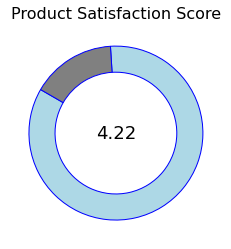

In [15]:
''' Visualize the score'''

avg = np.round(df['rating'].mean(), 2)
score = np.round(np.round(df['rating'].mean(), 2)/5*100,0)
remaining = (5-np.round(df['rating'].mean(), 2))/5*100

fig, ax = plt.subplots(figsize=(4, 4))
wedgeprops = {'width':0.3, 'edgecolor':'blue', 'linewidth':1}
ax.pie([score,remaining], wedgeprops=wedgeprops, startangle=150, colors=['#ADD8E6', '#808080'])
plt.title('Product Satisfaction Score', fontsize=16)
plt.text(0, 0, avg, ha='center', va='center', fontsize=18)
plt.show()

In [17]:
'''Get count of reviews per score'''

count_of_reviews = df.groupby('rating').agg(count = ('rating', 'count')).reset_index()
count_of_reviews

,rating,count
0,1.0,503
1,2.0,111
2,3.0,150
3,4.0,209
4,5.0,2679


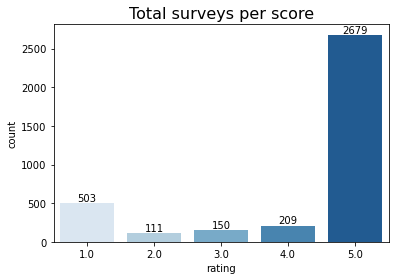

In [18]:
'''Visualize count of reviews per score'''

ax = sns.barplot(x=count_of_reviews['rating'],y=count_of_reviews['count'], data=count_of_reviews, palette= 'Blues')
plt.title('Total surveys per score', fontsize = 16)
ax.bar_label(ax.containers[0])
plt.show()

### Use a trained ML Model to predict the Polarity scores from each review 

In [19]:
'''Classify existing data into 3 groups, postive = 4 and 5, neutral = 3, negative = 1 and 2'''

def polarity_score(num):
    
    ''' Positive = 0, neutral =1, negative = 2'''
    
    if num == 3:
        return 1
    elif num >3:
        return 0
    else:
        return 2



df['polarity'] = df['rating'].apply(polarity_score)

In [20]:
'''The below shows inequality distribution, so we need to use stratified while spliting the data'''

df['polarity'].value_counts()

0    2888
2     614
1     150
Name: polarity, dtype: int64

In [21]:
'''We need to remove the stop words from each review'''

def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    try:
        for token in doc:
            if token.is_stop or token.is_punct:
                continue
            filtered_tokens.append(token.lemma_)
    except ValueError:
        pass
    return " ".join(filtered_tokens) 

In [22]:
''' Create new column include the text after excluding the stopwords'''

df['preprocessed_text'] = df['body'].astype(str).apply(preprocess)

In [23]:
'''Comparison'''

print(df['body'][0],'\n')
print(df['preprocessed_text'][0])

Grabbed this at the current sale price of $90. Much better deal than buying from Apple directly right now.It connected seamlessly with my iPad Pro 12.9” and charges as expected.It will take me some time to get used to using it(I haven’t used a stylus on a regular basis before) and I will most likely end up buying a “paper feel” screen protector, because I am skipping all over my tempered glass one with it. And I’ll also probably end up getting one of those silicone grips to slide over the lower portion, because I find its shape a little uncomfortable to grip for extended lengths of time.Despite my minor quibbles, which are all on me, I am very happy with this stylus and love how it helps me with my productivity. 

grab current sale price $ 90 well deal buy Apple directly right connect seamlessly iPad Pro 12.9 charge expect time it(I stylus regular basis likely end buy paper feel screen protector skip temper glass probably end get silicone grip slide low portion find shape little uncomf

In [24]:
df = df.rename_axis('Id').reset_index()
df.head()

,Id,title,rating,body,polarity,preprocessed_text
0,0,Pretty Nifty,5.0,Grabbed this at the current sale price of $90....,0,grab current sale price $ 90 well deal buy App...
1,1,Works As Expected But A Bit Slippery,5.0,I've had this for about 2+ months and it's bee...,0,2 + month work like expect Apple pencil authen...
2,2,Works as expected,5.0,The pencil itself is pretty basic. I found the...,0,pencil pretty basic find build note app good 3...
3,3,apple rocks,5.0,got this at 79usd.i cant imagine anyone can co...,0,get 79usd.i not imagine complain apple 14 pro ...
4,4,Must Have for my Ipad Pro,5.0,I used my fingers for years on my iPad. Then m...,0,finger year iPad friend tell pencil ipad hesit...


In [25]:
'''Identify X & y labels'''

X = df['preprocessed_text']
y = df['polarity']

In [26]:
'''Spliting the data'''

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                   random_state=42, stratify = y)

In [27]:
print(len(X_train))
print(len(X_test))
print(len(y_train), '\n',y_train.value_counts())
print(len(y_test), '\n',y_test.value_counts())

2556
1096
2556 
 0    2021
2     430
1     105
Name: polarity, dtype: int64
1096 
 0    867
2    184
1     45
Name: polarity, dtype: int64


In [46]:
'''Create pipeline, using CountVectorizer method and Random Forest approach to classify the data'''

clf = Pipeline([
    ('vectorizer_count',CountVectorizer()),        
    ('Random Forest', RandomForestClassifier(n_estimators=100 )) 
    
])

In [47]:
'''Train the model using X_train and y_train, then predect the values using X_test'''

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [48]:
'''Print classfication report to check precision, recall and f1 score'''

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       867
           1       0.00      0.00      0.00        45
           2       0.75      0.66      0.70       184

    accuracy                           0.88      1096
   macro avg       0.55      0.54      0.55      1096
weighted avg       0.84      0.88      0.86      1096



#### The above model shows very good predection when it comes to positive reviews, hwoever it shows good score when it comes to negative reviews, and very bad performance when it comes to neutral reviews

#### This was the third classifier model has been used, first I used KNN and Naive Bayes, but Random forest shows the best results it can provide

#### Also we have used TF - IDF tekonizer method, but it showed very low accuracy for negative reviews (56%), and slightly lower score for postive reviews (92%)

### 

### The same using any pre trained Model

##### Will use transformers roberta model, in case if any error while running the below cell, please open the this link in new tab

#####  https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment

In [31]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [32]:
'''Using roberta model to get the polarity score'''

def polarity_scores_roberta(text):
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict






res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['preprocessed_text']
        myid = row['Id']
        roberta_result = polarity_scores_roberta(text)
        res[myid] = roberta_result
    except RuntimeError:
        print(f'Broke for id {myid}')



  0%|          | 0/3641 [00:00<?, ?it/s]

In [33]:
'''create new data frame with roberta scores'''

roberta_df = pd.DataFrame(res).T
roberta_df = roberta_df.reset_index().rename(columns={'index': 'Id'})
roberta_df = roberta_df.merge(df, how='right')

In [34]:
roberta_df.head()

,Id,roberta_neg,roberta_neu,roberta_pos,title,rating,body,polarity,preprocessed_text
0,0,0.016871,0.122349,0.860781,Must Have for my Ipad Pro,5.0,I used my fingers for years on my iPad. Then m...,0,finger year iPad friend tell pencil ipad hesit...
1,1,0.045193,0.653120,0.301687,Best pen of any I've used,5.0,"I am not a fan of apple products in general, s...",0,fan apple product general mixed feeling deny d...
2,2,0.026139,0.214068,0.759793,Works great!,5.0,"connected great, draws just fine! sometimes, t...",0,connect great draw fine tip twist get little l...
3,3,0.002702,0.027709,0.969589,Great for notes,5.0,I see a lot of reviews saying this pencil is f...,0,lot review say pencil fantastic drawing purcha...
4,4,0.001559,0.015154,0.983287,Nice & Accurate Apple Pencil (2nd Generation),5.0,This 2nd Generation Apple Pencil is nice! It's...,0,2nd generation Apple Pencil nice easy connect ...


### Create a View with Main Score vs Predicted Score

#### Visualization for SK Learn Model

Text(33.0, 0.5, 'Truth')

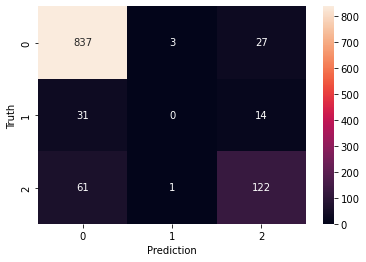

In [49]:
'''Plot confusion metrics'''

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

#### Visualization for roberta Model

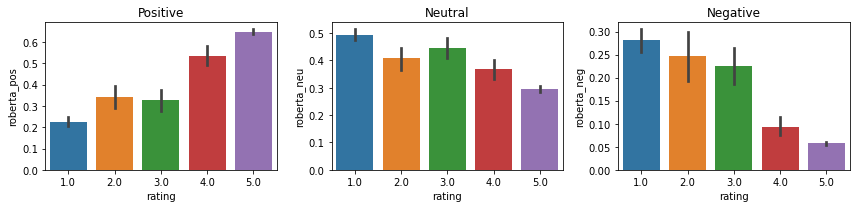

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=roberta_df, x='rating', y='roberta_pos', ax=axs[0])
sns.barplot(data=roberta_df, x='rating', y='roberta_neu', ax=axs[1])
sns.barplot(data=roberta_df, x='rating', y='roberta_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

### Create a View showing the main repeated issues, Filter dataframe with Negative Review (< 3 Score)

In [37]:
df_negative = roberta_df[roberta_df['rating']<3].reset_index()
df_negative.drop('index', axis=1, inplace=True)
df_negative.head()

,Id,roberta_neg,roberta_neu,roberta_pos,title,rating,body,polarity,preprocessed_text
0,71,0.358894,0.562736,0.078370,Amazon sold me a used one!,1.0,I ordered this Apple Pencil in anticipation fo...,2,order Apple Pencil anticipation new IPad Air 4...
1,327,0.050872,0.478064,0.471063,"Great product, too delicate",2.0,The pencil is a great product and is a game ch...,2,pencil great product game changer people use l...
2,328,0.586411,0.365374,0.048216,What you don't know about Apple defective prod...,1.0,I bought a defective Apple Pencil probably for...,2,buy defective Apple Pencil probably $ 100 work...
3,344,0.417609,0.492888,0.089504,don't drop it!,1.0,"A: Write with it, store it, and drop it.Q: Wha...",2,write store drop q 3 common thing people pen p...
4,432,0.128103,0.579107,0.292791,My god this is an overpriced piece of crap.,2.0,They literally design this thing to get lost. ...,2,literally design thing lose happen clip magnet...


In [38]:
print(len(df_negative))

614


In [39]:
docs = list(nlp.pipe(df_negative.preprocessed_text))

In [40]:
'''Extract tokens and metadata from every doc and add it into dataframe'''

def extract_tokens_data(doc:spacy.tokens.doc.Doc):

    return [(i.text.lower(), i.i, i.lemma_, i.ent_type_, i.tag_, 
         i.dep_, i.pos_, i.is_stop, i.is_alpha, 
         i.is_digit, i.is_punct) for i in doc]


def tidy_tokens(docs):
    
    cols = [
        "doc_id", "token", "token_order", "lemma", 
        "ent_type", "tag", "dep", "pos", "is_stop", 
        "is_alpha", "is_digit", "is_punct"
    ]
    
    meta_df = []
    try:
        for ix, doc in enumerate(docs):
            meta = extract_tokens_data(doc)
            meta = pd.DataFrame(meta)
            meta.columns = cols[1:]
            meta = meta.assign(doc_id = ix).loc[:, cols]
            meta_df.append(meta)
    except ValueError:
        pass
    
    return pd.concat(meta_df)


In [41]:
tidy = tidy_tokens(docs)
len(tidy)

6018

In [42]:
tidy.head()

,doc_id,token,token_order,lemma,ent_type,tag,dep,pos,is_stop,is_alpha,is_digit,is_punct
0,0,order,0,order,,NN,nsubj,NOUN,False,True,False,False
1,0,apple,1,Apple,ORG,NNP,compound,PROPN,False,True,False,False
2,0,pencil,2,Pencil,ORG,NNP,compound,PROPN,False,True,False,False
3,0,anticipation,3,anticipation,,NN,nsubj,NOUN,False,True,False,False
4,0,new,4,new,,JJ,ccomp,ADJ,False,True,False,False


In [43]:
'''Removing numaric data'''

filtered_tidy = tidy[(tidy['pos'] != 'NUM') &(tidy['is_alpha'] == True)].reset_index()


In [44]:
len(filtered_tidy)

5594

In [45]:
Top_repeated = filtered_tidy.groupby('lemma').agg(count = ('lemma', 'count')).reset_index().sort_values('count', ascending= False)
print(Top_repeated.head(20))


         lemma  count
852     pencil    189
1306      work    155
7        Apple    149
260     charge    105
229        buy     89
602       iPad     87
780        new     84
60      Pencil     68
150      apple     66
906    product     60
851        pen     57
988     return     55
1191      time     51
301    connect     50
6       Amazon     46
212        box     45
1193       tip     42
922   purchase     41
1253       use     41
686       like     40


## The most common words conclusion based on most repeated words:

#### The pencil doesn't work mostly with iPad, and in some cases it does not connect
#### Customer wants to return it with no charge
#### There is issue with pakaging (could be assumed from word box)

### 

### Add the comment insights to Wordcloud Chart to present the issues 

In [46]:
low = ' '
for i in range(len(filtered_tidy)):
    item = filtered_tidy['lemma'][i].strip().lower()
    low = low + ' ' + item

In [47]:
wc = WordCloud(
    background_color='white',
    height= 300,
    width =600
)

In [48]:
wc.generate(low)

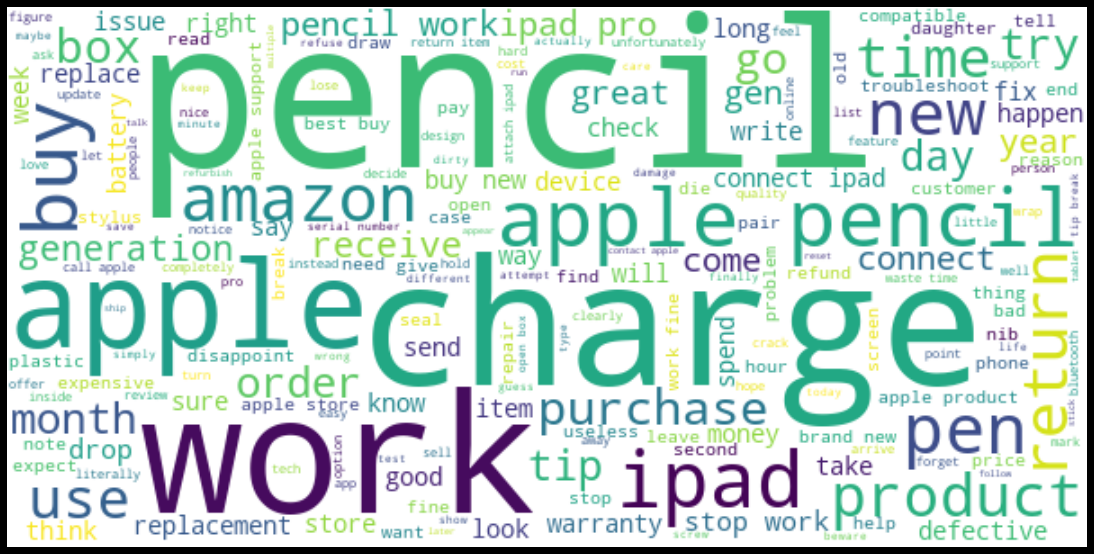

In [49]:
plt.figure(figsize=(15,10), facecolor='k' )
plt.imshow(wc,  interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Extraxting data frame

In [50]:
all_df = roberta_df.copy()
top_df = roberta_df[roberta_df['rating'].isin([4,5])]
bottom_df = roberta_df[roberta_df['rating'].isin([1,2])]

In [51]:
selection = input('Would you like to extract the dataframe? [Y / N]:\n').lower().strip()

stat = True

while stat:
    if not selection in ['y','n']:
        print('Please enter either Y or N to proceed')
        selection = input('Would you like to extract the dataframe? [Y / N]:\n').lower().strip()
        
    elif selection == 'n':
        print('Thanks for using Company\'s NLP model')
        stat = False
    elif selection == 'y':
        df_type = input('Please select one of the below choices:\nTo extract all data please enter 1\nTo extract top rated data please enter 2\nTo extract low rated data please enter3\n\n').strip()
        while stat:
            if not df_type in ['1','2','3']:
                print('Please select valid chice to proceed')
                df_type = input('Please select one of the below choices:\nTo extract all data please enter 1\nTo extract top rated data please enter 2\nTo extract low rated data please enter 3\n\n').strip()
            elif df_type == '1':
                all_df.to_excel('Full_data.xlsx')
                print('Full data has been extracted successfully. Thanks for using Company\'s NLP model')
                stat = False
            elif df_type == '2':
                top_df.to_excel('Top_rated_data.xlsx')
                print('Top rated data has been extracted successfully. Thanks for using Company\'s NLP model')
                stat = False
            elif df_type == '3':
                bottom_df.to_excel('Low_rated_data.xlsx')
                print('Low rated data has been extracted successfully. Thanks for using Company\'s NLP model')
                stat = False


Would you like to extract the dataframe? [Y / N]:
n
Thanks for using Raya's machine learning model


## Thank You :)

#

#